In [3]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("D:\BKAI\detr_outputs_v3", id2label={0:"motorbike", 1: "car", 2: "coach", 3: "truck"})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
image_processor = DetrImageProcessor.from_pretrained("D:\BKAI\detr_outputs_v3")

<>:4: SyntaxWarning: invalid escape sequence '\B'
<>:7: SyntaxWarning: invalid escape sequence '\B'
<>:4: SyntaxWarning: invalid escape sequence '\B'
<>:7: SyntaxWarning: invalid escape sequence '\B'
C:\Users\MINH HUNG\AppData\Local\Temp\ipykernel_3756\2254414967.py:4: SyntaxWarning: invalid escape sequence '\B'
  model = DetrForObjectDetection.from_pretrained("D:\BKAI\detr_outputs_v3", id2label={0:"motorbike", 1: "car", 2: "coach", 3: "truck"})
C:\Users\MINH HUNG\AppData\Local\Temp\ipykernel_3756\2254414967.py:7: SyntaxWarning: invalid escape sequence '\B'
  image_processor = DetrImageProcessor.from_pretrained("D:\BKAI\detr_outputs_v3")


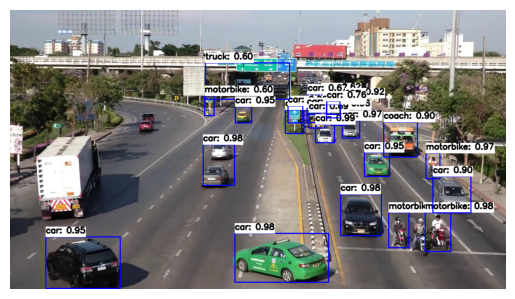

In [4]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2
import matplotlib.pyplot as plt

# Định nghĩa hàm dự đoán
def predict_on_image(image_path):
    # Đọc ảnh
    image = cv2.imread(image_path)
    inputs = image_processor(images=image, return_tensors='pt').to("cuda" if torch.cuda.is_available() else "cpu")
    
    # Thực hiện dự đoán
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Kích thước ảnh đầu ra
    target_sizes = torch.tensor([image.shape[:2]]).to("cuda" if torch.cuda.is_available() else "cpu")
    results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.3)[0]
    
    # Vẽ bounding box lên ảnh
    for box, score, label_id in zip(results['boxes'], results['scores'], results['labels']):
        if score > 0.5:  # Sử dụng ngưỡng mà bạn đã quyết định
            label = f"{model.config.id2label[label_id.item()]}: {score:.2f}"
            box = [int(coord.item()) for coord in box]  # Chuyển đổi tọa độ box thành số nguyên
            
            # Vẽ bounding box
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 0), thickness=2)  # Màu đỏ
            
            # Thêm nền cho text
            text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)[0]
            text_bg = (box[0], box[1] - text_size[1] - 10, box[0] + text_size[0], box[1])
            cv2.rectangle(image, (text_bg[0], text_bg[1]), (text_bg[2], text_bg[3]), (255, 255, 255), thickness=cv2.FILLED)
            
            # Vẽ văn bản
            cv2.putText(image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, cv2.LINE_AA)
    
    # Hiển thị ảnh
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Thử nghiệm với một hình ảnh
image_path = r'D:\BKAI\AIO_2024\Traffic Vehicle Detection\public test\public test\src_1_frame_199_jpg.rf.7992e359696bc914bf0d244d0b6c0b63.jpg'
predict_on_image(image_path)


Ghi vào file txt

In [8]:
import os
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2

# Đường dẫn đến thư mục chứa ảnh và file kết quả
image_folder = r'D:\BKAI\AIO_2024\Traffic Vehicle Detection\public test\public test'
output_file = r'D:\BKAI\predict\predict.txt'


# Hàm chuyển đổi bounding box sang định dạng YOLO
def convert_bbox_to_yolo(box, image_width, image_height):
    x_min, y_min, x_max, y_max = box
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    x_center = x_min + bbox_width / 2
    y_center = y_min + bbox_height / 2
    
    # Chuyển đổi tọa độ sang tỷ lệ (0-1)
    return [
        x_center / image_width,
        y_center / image_height,
        bbox_width / image_width,
        bbox_height / image_height
    ]

# Tạo hoặc mở file để ghi kết quả
with open(output_file, 'w') as f:
    # Duyệt qua tất cả các ảnh trong thư mục
    for image_name in os.listdir(image_folder):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_folder, image_name)
            image = cv2.imread(image_path)
            img_height, img_width = image.shape[:2]

            # Chuẩn bị đầu vào
            inputs = image_processor(images=image, return_tensors='pt').to(device)
            
            # Dự đoán
            with torch.no_grad():
                outputs = model(**inputs)

            # Xử lý kết quả
            target_sizes = torch.tensor([image.shape[:2]]).to(device)
            results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.3)[0]

            # Lặp qua các kết quả và ghi vào file
            for box, score, label_id in zip(results['boxes'], results['scores'], results['labels']):
                if score > 0.7:
                    yolo_bbox = convert_bbox_to_yolo([coord.item() for coord in box], img_width, img_height)
                    yolo_bbox_str = ' '.join([f"{coord:.8f}" for coord in yolo_bbox])
                    class_id = label_id.item()
                    f.write(f"{image_name} {class_id} {yolo_bbox_str} {score:.8f}\n")

print("Hoàn thành dự đoán và ghi kết quả vào file predict.txt.")


KeyboardInterrupt: 

Thay đổi class id

In [3]:
# Đường dẫn đến file predict.txt
file_path = r'D:\BKAI\predict\predict.txt'

# Tạo một dictionary để thay thế các nhãn
label_mapping = {
    "motorbike": "0",
    "car": "1",
    "coach": "2",
    "truck": "3"
}

# Đọc nội dung file và thay thế nhãn
with open(file_path, 'r') as file:
    lines = file.readlines()

with open(file_path, 'w') as file:
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 2:  # Kiểm tra nếu dòng có ít nhất 2 phần tử
            label = parts[1]
            if label in label_mapping:
                parts[1] = label_mapping[label]  # Thay thế nhãn
            file.write(' '.join(parts) + '\n')

print("Đã thay thế nhãn trực tiếp trong file.")


Đã thay thế nhãn trực tiếp trong file.


In [9]:
import os

# Đường dẫn đến thư mục cần đếm
folder_path = r'D:\BKAI\AIO_2024\Traffic Vehicle Detection\public test\public test'

# Đếm số lượng file trong thư mục
file_count = sum(1 for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file)))

print(f"Số lượng file trong thư mục: {file_count}")


Số lượng file trong thư mục: 2060
